In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import itertools
import os
from pathlib import Path
import pvlib
from matplotlib import pyplot as plt

In [2]:
def load_pvgis_df(path):
    with open(path, "r") as csv_file:
        header_line_index = None
        empty_line_index = None
        for i, line in enumerate(csv_file):
            if header_line_index is None:
                if line.strip() == "time,P,G(i),H_sun,T2m,WS10m,Int":
                    header_line_index = i
            elif not line.strip():
                empty_line_index = i
                break
        if header_line_index is None or empty_line_index is None:
            raise ValueError("header or footer not found in solar CSV")

    solar_df = pd.read_csv(
        path,
        skiprows=header_line_index,
        nrows=empty_line_index - header_line_index - 1,
    )

    solar_df = pd.DataFrame(
        {
            "exp_power": solar_df["P"].values,
            "poa_irradiance": solar_df["G(i)"].values,
        },
        index=pd.DatetimeIndex(
            pd.to_datetime(solar_df["time"], format="%Y%m%d:%H%M", utc=True).rename(
                None
            )
        ).tz_convert("Europe/London"),
    )

    return solar_df

pvgis_df = load_pvgis_df('../../data/Timeseries_52.772_-1.209_SA_3kWp_crystSi_14_39deg_-3deg_2013_2015.csv')
pvgis_df.describe()

,exp_power,poa_irradiance
count,26280.000000,26280.000000
mean,375.721697,133.994022
std,660.290746,229.184162
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,451.975000,167.975000
max,3035.660000,1093.200000


In [3]:
def load_bsrn_df(path):
    with open(path, "r") as csv_file:
        comment_line_count = None
        for i, line in enumerate(csv_file):
            if i == 0:
                if not line.strip().startswith('/*'):
                    raise ValueError('expected comment starting on first line')
            elif line.strip().endswith('*/'):
                    comment_line_count = i + 1
                    break
        if comment_line_count is None:
            raise ValueError("end of comment not found")
    
    df = pd.read_csv(
        path,
        index_col=0,
        skiprows=comment_line_count,
        sep='\t',
        parse_dates=True,
    )
    df = df.tz_localize('UTC').tz_convert('Europe/London')
    df = df.rename(columns={
        'Height [m]': 'height',
        'SWD [W/m**2]': 'swd',
        'DIR [W/m**2]': 'dir',
        'DIF [W/m**2]': 'dif',
        'LWD [W/m**2]': 'lwd',
    })[['swd', 'dir', 'dif']]
    return df

bsrn_df = load_bsrn_df('../../data/bsrn/cam0614.csv')
bsrn_df.describe()

,swd,dir,dif
count,43200.000000,43200.000000,43200.000000
mean,273.481921,236.805787,118.787037
std,316.933410,328.834865,141.024528
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,130.000000,2.000000,71.000000
75%,489.000000,524.000000,189.000000
max,1332.000000,966.000000,755.000000


In [4]:
bsrn_df.sample(5)

,swd,dir,dif
Date/Time,,,
2014-06-21 03:50:00+01:00,0,0,0
2014-06-21 14:10:00+01:00,920,881,125
2014-06-03 07:12:00+01:00,133,19,129
2014-06-30 07:15:00+01:00,151,12,148
2014-06-19 16:45:00+01:00,675,855,85


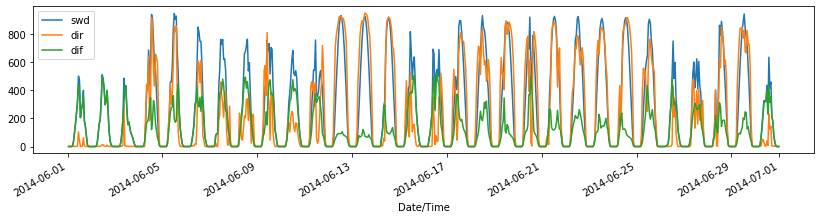

In [5]:
bsrn_df.resample('h').mean().plot(figsize=(14, 3));

In [6]:
def load_weather_df(path):
    with open(path, "r") as csv_file:
        skip_line_count = None
        last_line_index = None
        for i, line in enumerate(csv_file):
            if line.strip() == 'data':
                if skip_line_count is not None:
                    raise ValueError('duplicate start of data')
                skip_line_count = i + 1
            if line.strip() == 'end data':
                if last_line_index is not None:
                    raise ValueError('duplicate end of data')
                last_line_index = i - 1
        if skip_line_count is None:
            raise ValueError("start of data not found")
        if last_line_index is None:
            raise ValueError("end of data not found")
    
    df = pd.read_csv(
        path,
        index_col=0,
        usecols=['ob_time', 'wind_speed_unit_id', 'wind_speed', 'air_temperature'],
        skiprows=skip_line_count,
        nrows=last_line_index - skip_line_count,
        parse_dates=True,
    )
    df = df.tz_localize('UTC')
    
    if (df.wind_speed_unit_id != 4).any():
        raise ValueError('unsupported wind speed unit')
    df = df.drop(columns=['wind_speed_unit_id'])
    df.wind_speed *= 0.514444 # convert to m/s
    
    return df
        
weather_df = load_weather_df(
    '../../data/uk_met_office/midas-open_uk-hourly-weather-obs_dv-201908_cornwall_01395_camborne_qcv-1_2014.csv',
)
weather_df.dropna(inplace=True)
weather_df.describe()

,wind_speed,air_temperature
count,8757.000000,8757.000000
mean,5.197664,11.578611
std,2.886955,3.985031
min,0.000000,-0.600000
25%,3.086664,8.500000
50%,4.629996,11.200000
75%,6.687772,14.800000
max,18.519984,26.200000


In [7]:
merged_df = bsrn_df.dropna().join(weather_df).resample('T').interpolate()
merged_df = merged_df.rename(columns={'dir': 'dni', 'swd': 'ghi', 'dif': 'dhi'})
merged_df.sample(5)

,ghi,dni,dhi,wind_speed,air_temperature
Date/Time,,,,,
2014-06-26 17:43:00+00:00,41,0,40,4.629996,16.225
2014-06-20 14:03:00+00:00,505,8,498,4.166996,18.650
2014-06-24 05:32:00+00:00,111,278,57,1.783406,13.500
2014-06-05 14:59:00+00:00,489,10,480,5.658884,14.200
2014-06-11 12:19:00+00:00,417,37,382,3.952645,14.990


In [8]:
# module_info = pvlib.pvsystem.retrieve_sam('CECMod')['LG_Electronics_Inc__LG350Q1C_A5']
module_info = pvlib.pvsystem.retrieve_sam('SandiaMod')['LG_LG290N1C_G3__2013_']
module_info

Vintage                                                          2013
Area                                                             1.64
Material                                                         c-Si
Cells_in_Series                                                    60
Parallel_Strings                                                    1
Isco                                                           9.8525
Voco                                                          39.6117
Impo                                                           9.2473
Vmpo                                                          31.2921
Aisc                                                           0.0002
Aimp                                                          -0.0004
C0                                                             1.0145
C1                                                            -0.0145
Bvoco                                                         -0.1205
Mbvoc               

In [9]:
inverter_info = pvlib.pvsystem.retrieve_sam('CECInverter')['Fronius_International_GmbH__Fronius_Primo_3_8_1_208_240__240V_']
inverter_info

Vac                   240
Pso               53.2528
Paco                 3800
Pdco              3911.35
Vdco                  650
C0           -3.14452e-06
C1                 -3e-05
C2               -4.8e-05
C3               0.000276
Pnt                  1.14
Vdcmax                800
Idcmax            6.01747
Mppt_low              100
Mppt_high             800
CEC_Date         3/1/2019
CEC_Type     Grid Support
Name: Fronius_International_GmbH__Fronius_Primo_3_8_1_208_240__240V_, dtype: object

In [30]:
system = pvlib.pvsystem.PVSystem(
    orientation_strategy='south_at_latitude_tilt',
    module_parameters=module_info,
    inverter_parameters=inverter_info,
    temperature_model_parameters=pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['close_mount_glass_glass'],
    racking_model='close_mount',
    modules_per_string=6,
    strings_per_inverter=2,
)

# Camborne (NOT Cambourne)
location = pvlib.location.Location(
    latitude=50.216660,
    longitude=-5.316660,
    tz='Europe/London',
    altitude=87,
)

model_chain = pvlib.modelchain.ModelChain(
    system,
    location,
    # aoi_model='no_loss',
)
model_chain.run_model(merged_df)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

/home/philippe/src/git.ihomelab.ch/SccerPhase2/load-shifting-potential/.venv/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


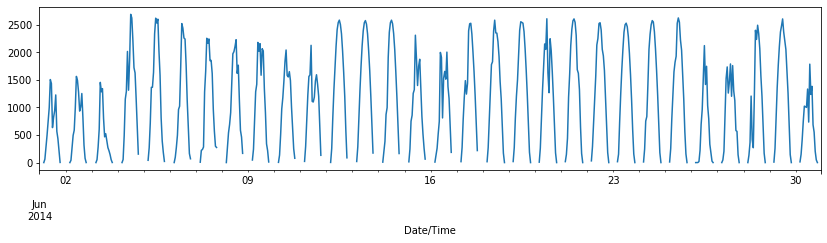

In [26]:
model_chain.ac.resample('h').mean().plot(figsize=(14, 3));

/home/philippe/src/git.ihomelab.ch/SccerPhase2/load-shifting-potential/.venv/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


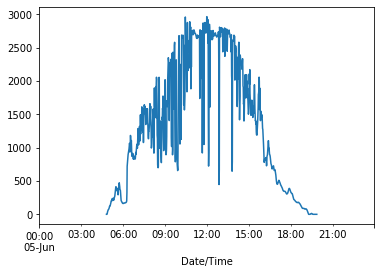

In [27]:
model_chain.ac['2014-06-05'].plot()

/home/philippe/src/git.ihomelab.ch/SccerPhase2/load-shifting-potential/.venv/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/home/philippe/src/git.ihomelab.ch/SccerPhase2/load-shifting-potential/.venv/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


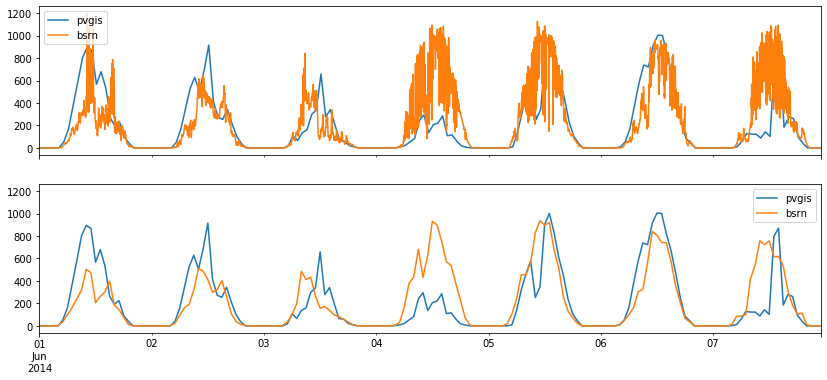

In [28]:
temp = [
    pd.DataFrame({
        'pvgis': pvgis_df['poa_irradiance'].resample('T').interpolate(),
        'bsrn': model_chain.total_irrad['poa_global'],
    }).dropna(),
    pd.DataFrame({
        'pvgis': pvgis_df['poa_irradiance'].resample('H').first(),
        'bsrn': model_chain.total_irrad['poa_global'].resample('H').mean(),
    }).dropna(),
]

fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True, sharey=True)
for i, df in enumerate(temp):
    df['2014-06-01':'2014-06-07'].plot(ax=ax[i]);

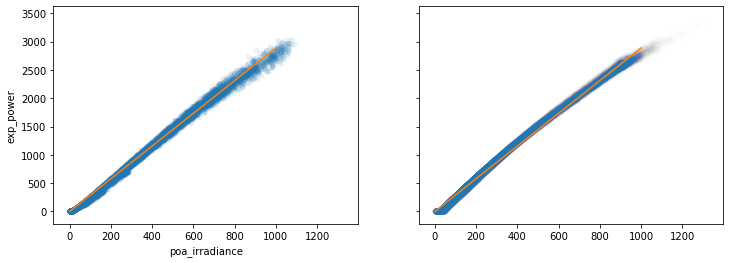

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

pvgis_df.plot.scatter('poa_irradiance', 'exp_power', alpha=0.005 * 12, ax=ax[0]);
ax[1].scatter(model_chain.total_irrad['poa_global'], model_chain.ac, alpha=0.005);

for i in range(2):
    ax[i].plot([0, 1000], [0, 3480 * 0.83], c='C1');